In [1]:
# Initialize for download
from bossHandler import bossHandler
from intern.resource.boss.resource import *
from intern.remote.boss import BossRemote
from skimage import filters
import numpy as np
from sklearn.mixture import GaussianMixture
from scipy.stats import norm

import matplotlib.pyplot as plt
from matplotlib import animation
import matplotlib.mlab as mlab


coll_name = 'ailey-dev'
exp_name = 'Insula_Atenolol-1_171204_new'
chan_name = 'Ch0'

bHandler = bossHandler(coll_name)
# bHandler.list_experiments()
bHandler.select_experiment(exp_name)
exp = bHandler.get_experiment()
bHandler.list_channels()
bHandler.select_channel(chan_name)
coor = bHandler.get_coordinate_frame()

# coord frame name = binarization_and_skeletonizationfrom intern.resource.boss.resource import *

In [2]:
# Helper functions for ingestation (from: vikram)
def get_channel_resource(rmt, chan_name, coll_name, exp_name, type='image', base_resolution=0, sources=[], datatype='uint16', new_channel=True):
    channel_resource = ChannelResource(chan_name, coll_name, exp_name, type=type, 
                                    base_resolution=base_resolution, sources=sources, datatype=datatype)
    if new_channel: 

        new_rsc = rmt.create_project(channel_resource)
        return new_rsc

    return channel_resource



def upload_to_boss(rmt, data, channel_resource, resolution=0):
    Z_LOC = 0
    size = data.shape
    for i in range(0, data.shape[Z_LOC], 16):
        last_z = i+16
        if last_z > data.shape[Z_LOC]:
            last_z = data.shape[Z_LOC]
        print(resolution, [0, size[2]], [0, size[1]], [i, last_z])
        rmt.create_cutout(channel_resource, resolution, [0, size[2]], [0, size[1]], [i, last_z], np.asarray(data[i:last_z,:,:], order='C'))

In [3]:
# download data from Boss
# data_cutout = bHandler.get_all()
coor = bHandler.get_coordinate_frame()
x_rng = [348, 500]
y_rng = [678, 878]
z_rng = [coor.z_start, coor.z_stop]

data_cutout = bHandler.get_cutout(x_rng, y_rng, z_rng)

data_cutout = data_cutout.astype('uint16')

In [ ]:
# gmm on whole volume
data_vol = np.copy(data_cutout)
gmm_nc = 2
# uniq = np.unique(data_vol , return_counts=True)
gmm = GaussianMixture(gmm_nc, covariance_type = 'full').fit(data_vol.reshape(-1,1))


cluster_labels = gmm.predict(data_vol.reshape(-1,1))
cluster_labels = cluster_labels.reshape(data_vol.shape)

In [ ]:
Z = 590
plt.figure()
plt.imshow(data_cutout[Z,:,:])

for i in range(gmm_nc):
    data_vol[cluster_labels == i] = 1
    data_vol[cluster_labels != i] = 0
    plt.figure()
    plt.imshow(data_vol[Z,:,:])

In [ ]:
# Visualize the output (animation)
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# z_rng = [0 , data_cutout.shape[0]]
z_rng = [500,600]
fig = plt.figure()
im = plt.imshow(data_vol[0,:,:], animated=True)

def animate(i):
    im.set_data(data_vol[i,:,:])
    im.autoscale()
    return im

anim = animation.FuncAnimation(fig, animate, frames = np.arange(z_rng[0],z_rng[1]), interval = 100)
HTML(anim.to_jshtml())

In [ ]:
print(cluster_labels.shape)

In [49]:
slice_n = 570
gmm_nc = 3

data_slice = np.copy(data_cutout[slice_n,:,:])
print(data_slice.shape)

# data_slice = data_slice/np.max(data_slice)

(200, 152)


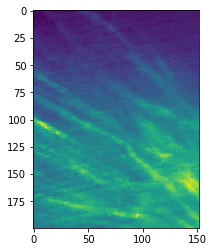

In [50]:
plt.imshow(data_slice)

In [51]:
uniq = np.unique(data_slice , return_counts=True)
# data_points = [p for p in zip(*uniq)]

# print(data_points[1])
# print(data_points)
# hist_norm = data_points[1].astype('float64')/np.max(data_points[1])
# plt.plot(hist_norm)
# plt.semilogx(data_points[1][50:500])
# plt.figure()
# plt.plot(data_points[1][50:500])


In [ ]:
print(uniq)

In [ ]:
# gmm = GaussianMixture(3 , covariance_type = 'full').fit(data_points)
# cluster_labels = gmm.predict(data_points)
# # y = gmm.score_samples(np.arange(50,500).reshape(-1,1))
# # plt.plot(np.arange(50,500) , y)
# # print(len(data_points[1]))
# print(gmm.covariances_.shape)
# print(gmm.means_)
# # print(cluster_labels.shape)

In [ ]:
print(data_slice.reshape(-1,1).shape)

In [52]:
gmm = GaussianMixture(gmm_nc, covariance_type = 'full').fit(data_slice.reshape(-1,1))

In [53]:
x = np.arange(uniq[0][0],uniq[0][-1])
gauss_mixt = np.array([p * norm.pdf(x, mu, sd) for mu, sd, p in zip(gmm.means_.flatten(), np.sqrt(gmm.covariances_.flatten()), gmm.weights_)])

In [43]:
x

array([ 3504,  3505,  3506, ..., 10591, 10592, 10593])

In [54]:
cluster_labels = gmm.predict(data_slice.reshape(-1,1))
print(gmm.means_)

[[ 4515.31185632]
 [ 7479.51875436]
 [ 6501.2483926 ]]


In [56]:
cluster_labels = cluster_labels.reshape(data_slice.shape)

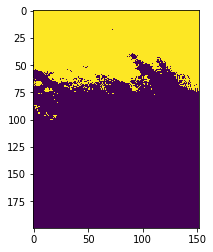

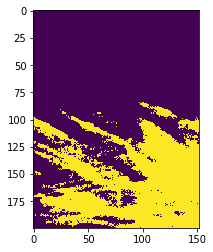

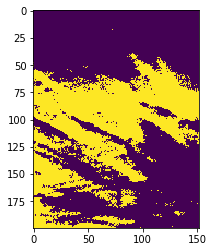

In [57]:
for i in range(gmm_nc):
    data_slice[cluster_labels == i] = 1
    data_slice[cluster_labels != i] = 0
    plt.figure()
    plt.imshow(data_slice)
    
#     plt.imshow(data_cutout[0,:,:])

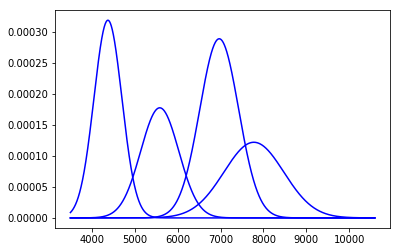

In [46]:
for i in range(len(gauss_mixt)):
    plt.plot(x, gauss_mixt[i], label = 'Gaussian '+str(i), color = 'blue')

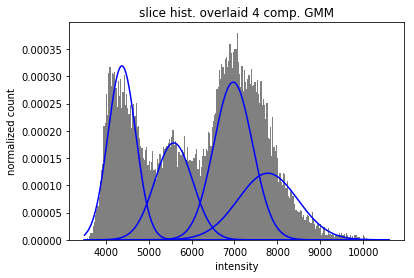

In [47]:
# plot histogram overlaid by gmm gaussians
data_slice = np.copy(data_cutout[slice_n,:,:])
for i in range(len(gauss_mixt)):
    plt.plot(x, gauss_mixt[i], label = 'Gaussian '+str(i), color = 'blue')

plt.hist(data_slice.reshape(-1,1),bins=256,density=True, color='gray')
plt.title('slice hist. overlaid ' + str(gmm_nc) + ' comp. GMM')
plt.xlabel('intensity')
plt.ylabel('normalized count')
plt.show()




In [ ]:

# for i in np.arange(0,3):
i = 0
# plt.semilogx(data_points[1][50:500])
plt.semilogx(uniq[1])
# plt.figure()
# plt.semilogx(mlab.normpdf(np.arange(0,data_points[1].shape[0]), gmm.means_[i][0], np.sqrt(gmm.covariances_[i][0][0])))
plt.show()


In [ ]:
# slice by slice otsu
vol_size = data_cutout.shape

for i in np.arange(0 , vol_size[0]):
    curr_slice = data_cutout[i,:,:]
    thresh = filters.threshold_otsu(curr_slice)
    curr_slice[curr_slice <= thresh ] = np.uint16(0)
    curr_slice[curr_slice > thresh ] = np.uint16(1)
    data_cutout[i,:,:] = curr_slice
    

In [ ]:
# whole volumme otsu
thresh = filters.threshold_otsu(data_cutout)
print(thresh)
data_cutout[data_cutout <= thresh] = np.uint16(0)
data_cutout[data_cutout > thresh] = np.uint16(1)

In [ ]:
# Visualize the output (animation)
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

z_rng = [0 , data_cutout.shape[0]]
fig = plt.figure()
im = plt.imshow(data_cutout[0,:,:],animated=True)

def animate(i):
    im.set_data(data_cutout[i,:,:])
    return im

anim = animation.FuncAnimation(fig, animate, frames = np.arange(z_rng[0],z_rng[1]), interval = 100)
HTML(anim.to_jshtml())


In [ ]:
# apply gmm on whole data_cutout, slice by slice
data_vol = np.copy(data_cutout)
gmm_nc = 4
vol_size = data_vol.shape
for i in np.arange(0 , vol_size[0]):
    data_slice = data_vol[i,:,:]
    uniq = np.unique(data_slice , return_counts=True)
    
    gmm = GaussianMixture(gmm_nc, covariance_type = 'full').fit(data_slice.reshape(-1,1))
    cluster_labels = gmm.predict(data_slice.reshape(-1,1))
    cluster_labels = cluster_labels.reshape(data_slice.shape)
    x = np.arange(0,uniq[1].shape[0])
    c_id = np.argmax(gmm.means_) # index of the cluster with highest mean
    
    data_slice[cluster_labels == c_id] = 1
    data_slice[cluster_labels != c_id] = 0
    data_vol[i,:,:] = data_slice
    print(i)

In [ ]:
# Visualize the output (animation)
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# z_rng = [0 , data_cutout.shape[0]]
z_rng = [570,650]
fig = plt.figure()
im = plt.imshow(data_vol[590,:,:], animated=True)

def animate(i):
    im.set_data(data_vol[i,:,:])
    im.autoscale()
    return im

anim = animation.FuncAnimation(fig, animate, frames = np.arange(z_rng[0],z_rng[1]), interval = 100)
HTML(anim.to_jshtml())    
    

In [ ]:
# Ingest the results back to Boss
rmt = BossRemote()
new_coll_name = 'tractography'
new_exp_name = 'binarization_and_skeletonization'
new_chan_name = 'Ch0_4gmm_slice_by_slice'
create_new_channel = True

In [ ]:
if create_new_channel:
    # new channel
    new_chan_resource = get_channel_resource(rmt, new_chan_name, new_coll_name, new_exp_name , new_channel=True)
    upload_to_boss(rmt, data_cutout.astype('uint16'), new_chan_resource)
    
else:
    # get existing channel
    chan_resource = rmt.get_channel(chan_name= chan_name, coll_name=new_coll_name, exp_name=new_exp_name)
    upload_to_boss(rmt, data_cutout.astype('uint16'), chan_resource)

